In [1]:
import os

# standard libraries
import numpy as np
import matplotlib.pyplot as plt 

# import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

# custom library
from patchnmf.data_io import get_tiff, get_save_path, export_conts_fiji
from patchnmf.analyse.compute import downsample_tiff_avg, compute_nmfpx_blur_thr, get_thr_img_auto, get_roi_conts, get_loading_times 
from patchnmf.plot import plot_nmf_t, plot_nmfpx_blur_thr, plot_rois_overlay, plot_roi_conts_largest, plot_roi_area_hist, plot_px_nmf_corr, plot_roi_loading_time

# going to root directory (if not there yet)
current_dir = os.getcwd().split('/')[-1]
if current_dir != 'barrel-patch_analysis': 
    os.chdir('..')

# reload code if library changes
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
# defining analysis parameters
ds = 'ani34_2022-05-13_b' 

n_components = 20
blur_std = 6.5
downs_fact = 8 # keep as 1 for no downsampling IMPORTANT: downsampling will mean fewer significant components in cross-validation
resolution = 0.551 # in um 
movie_shape = (18000, 128, 128)

In [3]:
#creating a directory to save figures from mf processing 
import os
save_dir = f'data/{ds}/NMF/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    

In [4]:
tiff = get_tiff(ds)

file000_chan0.tif


/home/jure/anaconda3/envs/patchnmf/lib/python3.11/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int32 to uint16 without scaling because max value 3610 fits in uint16
  return _convert(image, np.uint16, force_copy)


file1000_chan0.tif


/home/jure/anaconda3/envs/patchnmf/lib/python3.11/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int32 to uint16 without scaling because max value 3409 fits in uint16
  return _convert(image, np.uint16, force_copy)


(1000, 1024, 1024)
file2000_chan0.tif


/home/jure/anaconda3/envs/patchnmf/lib/python3.11/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int32 to uint16 without scaling because max value 3444 fits in uint16
  return _convert(image, np.uint16, force_copy)


(1000, 1024, 1024)
file3000_chan0.tif


/home/jure/anaconda3/envs/patchnmf/lib/python3.11/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int32 to uint16 without scaling because max value 3848 fits in uint16
  return _convert(image, np.uint16, force_copy)


(1000, 1024, 1024)
file4000_chan0.tif


/home/jure/anaconda3/envs/patchnmf/lib/python3.11/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int32 to uint16 without scaling because max value 3928 fits in uint16
  return _convert(image, np.uint16, force_copy)


(1000, 1024, 1024)
file5000_chan0.tif


/home/jure/anaconda3/envs/patchnmf/lib/python3.11/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int32 to uint16 without scaling because max value 3482 fits in uint16
  return _convert(image, np.uint16, force_copy)


(1000, 1024, 1024)
file6000_chan0.tif


/home/jure/anaconda3/envs/patchnmf/lib/python3.11/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int32 to uint16 without scaling because max value 3431 fits in uint16
  return _convert(image, np.uint16, force_copy)


(1000, 1024, 1024)
file7000_chan0.tif


/home/jure/anaconda3/envs/patchnmf/lib/python3.11/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int32 to uint16 without scaling because max value 3705 fits in uint16
  return _convert(image, np.uint16, force_copy)


(1000, 1024, 1024)
file8000_chan0.tif


/home/jure/anaconda3/envs/patchnmf/lib/python3.11/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int32 to uint16 without scaling because max value 3606 fits in uint16
  return _convert(image, np.uint16, force_copy)


(1000, 1024, 1024)
Shape of video: (9000, 1024, 1024)


In [5]:
import sys
sys.getsizeof(tiff) 

18874368144

Done with 0 frames
Done with 100 frames
Done with 200 frames
Done with 300 frames
Done with 400 frames
Done with 500 frames
Done with 600 frames
Done with 700 frames
Done with 800 frames
Done with 900 frames
Done with 1000 frames
Done with 1100 frames
Done with 1200 frames
Done with 1300 frames
Done with 1400 frames
Done with 1500 frames
Done with 1600 frames
Done with 1700 frames
Done with 1800 frames
Done with 1900 frames
Done with 2000 frames
Done with 2100 frames
Done with 2200 frames
Done with 2300 frames
Done with 2400 frames
Done with 2500 frames
Done with 2600 frames
Done with 2700 frames
Done with 2800 frames
Done with 2900 frames
Done with 3000 frames
Done with 3100 frames
Done with 3200 frames
Done with 3300 frames
Done with 3400 frames
Done with 3500 frames
Done with 3600 frames
Done with 3700 frames
Done with 3800 frames
Done with 3900 frames
Done with 4000 frames
Done with 4100 frames
Done with 4200 frames
Done with 4300 frames
Done with 4400 frames
Done with 4500 frames


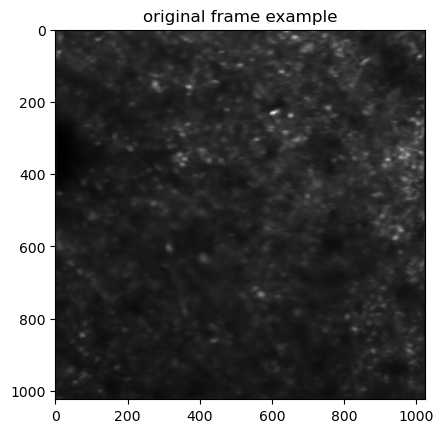

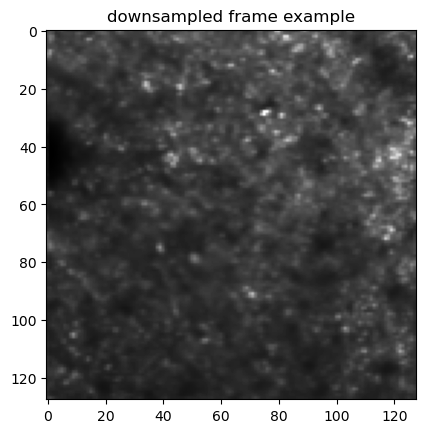

In [6]:
if downs_fact != 1:
    tiff = downsample_tiff_avg(tiff, n=downs_fact) # downsample (to speed up cross-validation) -> not done if downs_fact = 1
    

In [7]:
#flattening movie to input it to NMF (Negative *Matrix* Factorisation works on matrices, not tensors like movies)
# but its not problem because the results that we get can then be easily reshaped back into an x by y frame (FOV)
tiff = np.reshape(tiff, (tiff.shape[0] , tiff.shape[1]*tiff.shape[2]))

print(f'Shape of video as a matrix (input to NMF): {tiff.shape}')

Shape of video as a matrix (input to NMF): (9000, 16384)


# NMF on pixels

In [8]:
#initialising nmf and fitting to pixels
nmf_px = NMF(n_components=n_components, verbose=True)
nmf_px.fit(tiff)

violation: 1.0
violation: 2.225020360444793e-05
Converged at iteration 3


NMF(n_components=20, verbose=True)

In [9]:
# here we get the raw NMF component on pixels, raw NMF with gaussin blur and an automatically thresholded blurred NMF (binary 'ROI')
loading_imgs, loading_imgs_filt, rois_auto = compute_nmfpx_blur_thr(nmf_px, movie_shape, blur_std=blur_std)

Saving nmfpx_blur_thr.png ...


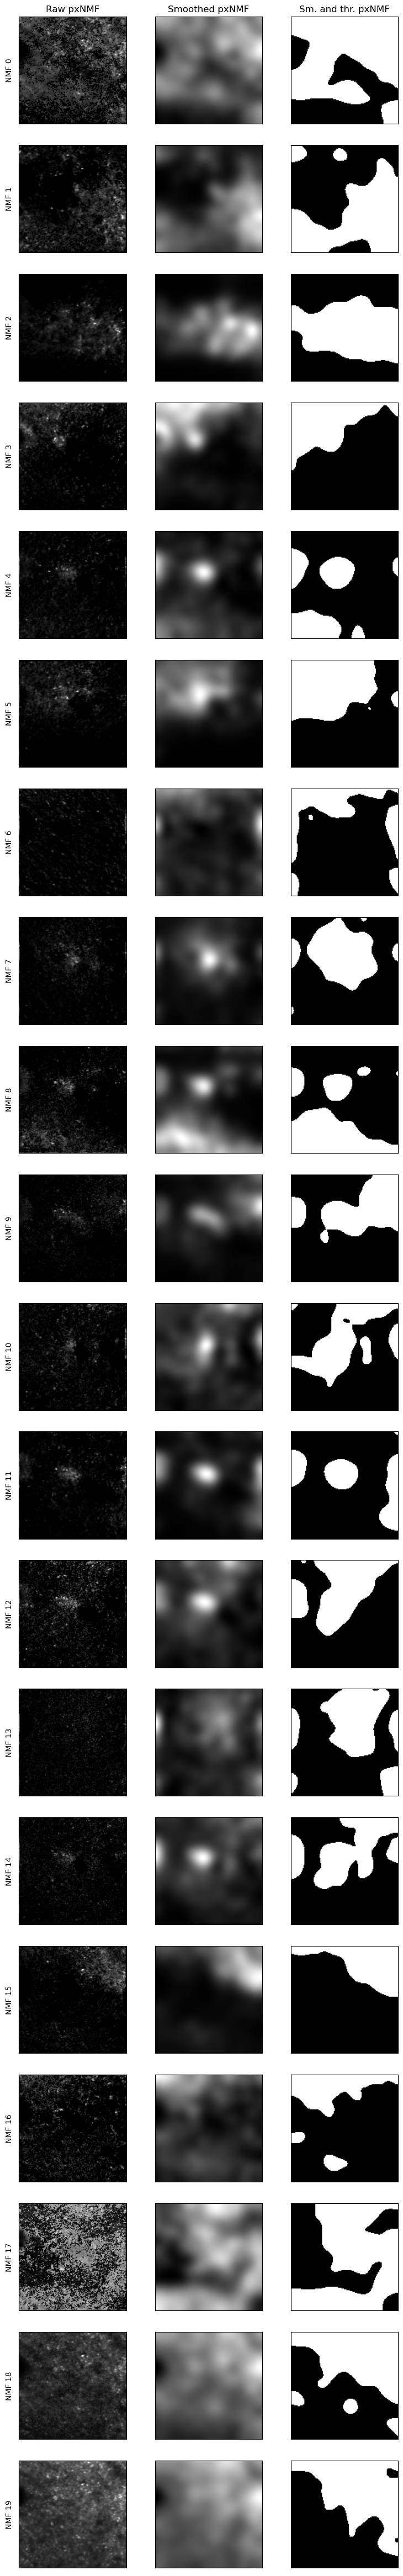

In [10]:
plot_nmfpx_blur_thr(loading_imgs, loading_imgs_filt, rois_auto, save_dir=save_dir) # this save=save says save when not none or sth 


Saving rois_overlay.png ...


<Figure size 1000x1000 with 0 Axes>

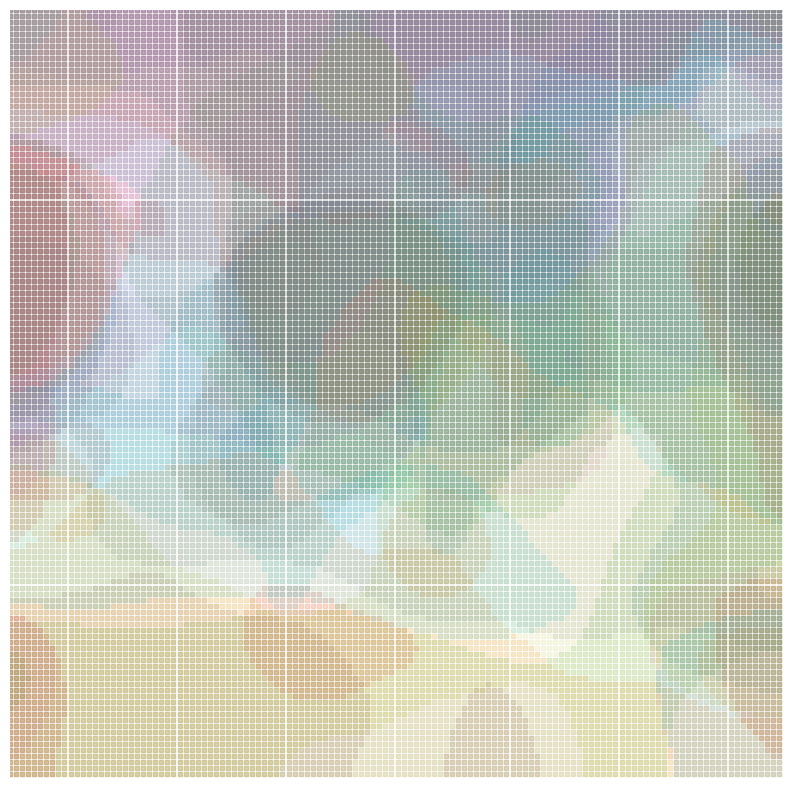

In [11]:
plot_rois_overlay(rois_auto, movie_shape, save_dir=save_dir) # this will look ugly for too many components, also probably not the best viusalisation

In [12]:
# this is a function that takes ROIs as a binary image (as above) and outputs the coordinates of points that would encircle them
conts, n_conts = get_roi_conts(rois_auto)

Saving rois_conts_largest.png ...


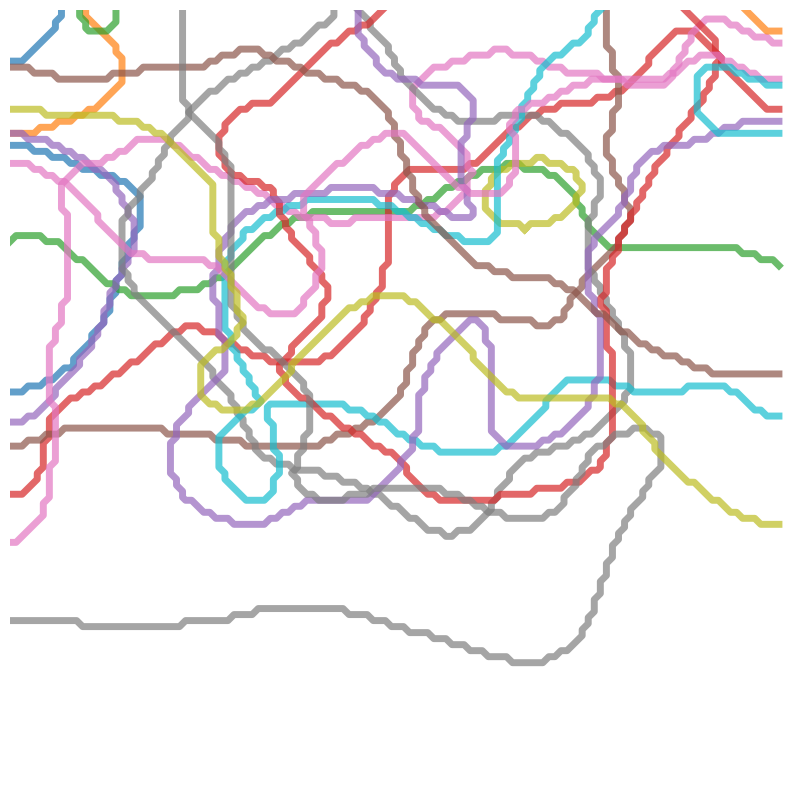

In [13]:
plot_roi_conts_largest(conts, movie_shape, save_dir=save_dir)

Saving roi_area_hist.png ...


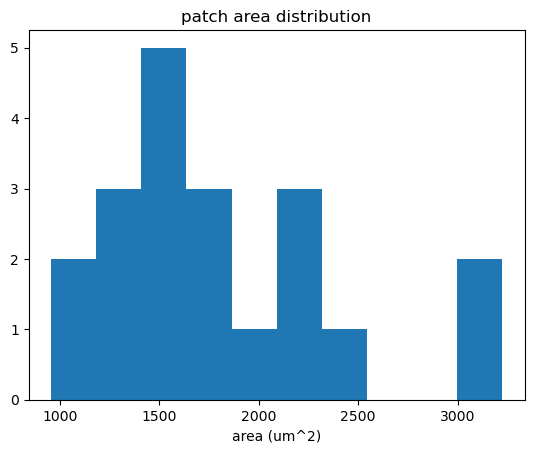

In [14]:
plot_roi_area_hist(rois_auto, n_bins=10, resolution=resolution, save_dir=save_dir)

Saving px_nmf_corr.png ...


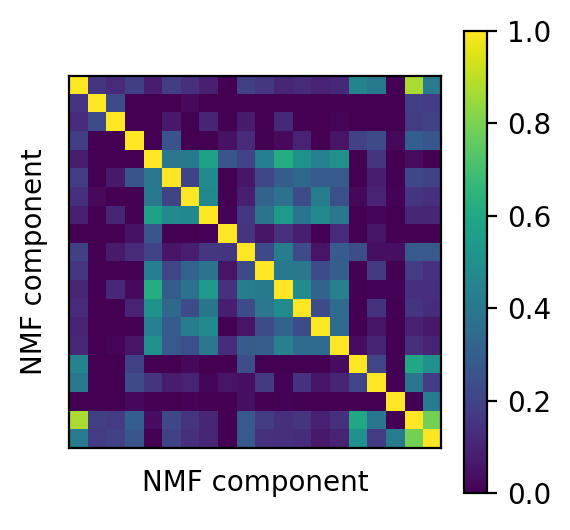

In [15]:
# looking at correlation (in the binary case this is somewhat equivalent to the percentage of overlap)
# NOTE: this plot is deceiving because it only shows positive correlations - it saturates the negative ones
plot_px_nmf_corr(nmf_px, save_dir=save_dir)

# Saving outputs

In [16]:
np.save(f'{save_dir}/nmf_px.npy', nmf_px, allow_pickle=True)